Use historical data for the  New Germany Fund (GF) to predict closing price for new five days


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
data_path = 'input/stock_prices_sample.csv'
df = pd.read_csv(data_path, index_col = 'DATE', parse_dates = ['DATE'])

In [23]:
df.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [24]:
df.dtypes

TICKER          object
FIGI            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME         float64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME     float64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO    float64
dtype: object

In [25]:
df.index


DatetimeIndex(['2013-01-04', '2013-01-03', '2013-01-02', '2018-06-05',
               '2018-06-04', '2018-06-01', '2018-05-31', '2018-05-30',
               '2018-05-29', '2018-05-25',
               ...
               '2014-07-07', '2014-07-03', '2014-07-02', '2014-07-01',
               '2014-06-30', '2014-06-27', '2014-06-26', '2014-06-25',
               '2014-06-24', '2014-06-23'],
              dtype='datetime64[ns]', name='DATE', length=999, freq=None)

In [26]:
def mape(y_pred, y_test):
    mape = 100*np.mean(np.abs((y_test-y_pred)/y_test))

Investigate types of funds - TICKER

In [29]:
df['TICKER'].unique()

array(['GEF', 'GF'], dtype=object)

In [30]:
df = df[df['TICKER']=='GF'] # only use ticker 'GF'

Investigate types of types - TYPE

In [31]:
df['TYPE'].unique()

array(['Intraday', 'EOD'], dtype=object)

In [32]:
df = df[df['TYPE']=='EOD'] # only look at 'EOD' - closing prices

In [33]:
cols_to_use = ['TICKER', 'OPEN', 'HIGH', 'LOW', 'CLOSE']
df = df[cols_to_use]
df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


In [38]:
print('min timestamp', df.index.values.min())
print('max timestamp', df.index.values.max())

min timestamp 2014-06-23T00:00:00.000000000
max timestamp 2018-06-04T00:00:00.000000000


Plot closing price

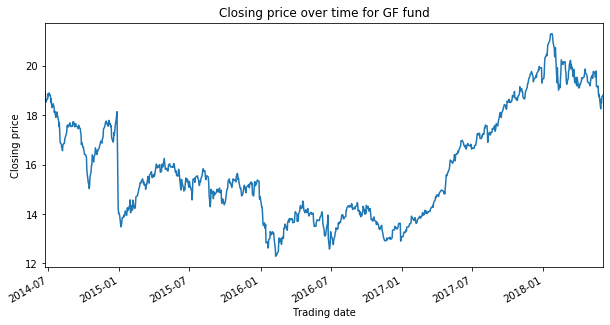

In [47]:
plt.figure(figsize = (10,5))
plt.plot(df['CLOSE'])
#df['CLOSE'].plot()
plt.title('Closing price over time for GF fund')
plt.xlabel('Trading date')
plt.ylabel('Closing price')
plt.show()

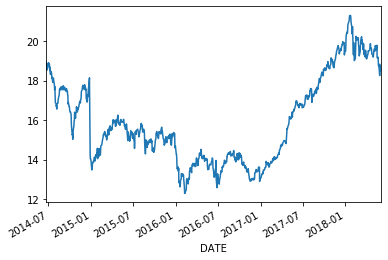

In [46]:
df.CLOSE.plot()